# Introducrtion to Machine Learning: Assignment #4
## Submission date: 31\07\2024, 23:55.
### Topics:
- Ensemble methods
- AdaBoost
- PCA
- LDA
- K means clustering

Submitted by:

 Ayal Kaabia - 322784760

 Bashar Bshouti - 207370248

**Assignment Instruction:**

· Submissions in pairs only.

· Try to keep the code as clean, concise, and short as possible

· If you wish to work in your IDE, you can, but you **must**,  insert the script back to the matching cells of the notebook and run the code. <br/>Only the notebook will be submitted in moodle (in `.ipynb` format).

· <font color='red'>Please write your answers to question in red</font>.

**Important:** All plots, results and outputs should be included in the notebook as the cells' outputs (run all cells and do not clear the output). <br/>

**Important:** Your submission must be entirely your own. Any attempts of plagiarism (including ChatGPT) will lead to grade 0 and disciplinary actions.


## Question 1 - Bagging
In HW3, you helped Charles Darvin with regression of abalone problem and now, you will try combining multiple regression models instead of just one, hopefully for a better result.

In [1]:
# import libraries

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

In [2]:
# load the data, transform it

df = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw3/abalone.csv', header=None)
data = df.to_numpy()

train, test = train_test_split(data, test_size=0.2, random_state=21)

X_train, y_train = train[:,:-1], train[:, -1]
X_test, y_test = test[:,:-1], test[:, -1]

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Your task is to complete the following bagging model. Specifically:
- fit(self, data, targets) - train n_estimators regressors, each with data in size n=len(data) that is drawn from the original data, with repititions.
- predict(self, test) - predict the result for all the regressors as learned.



In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
class LinRegCombiner():
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators

    def fit(self, data, targets):
        self.regressors = []

        for _ in range(self.n_estimators):
            # Implement here
            # Create a bootstrap sample
            data_sample, targets_sample = resample(data, targets)

            # Train a linear regression model
            regressor = LinearRegression()
            regressor.fit(data_sample, targets_sample)

            # Store the trained model
            self.regressors.append(regressor)

    def predict(self, test):
        preds = []
        # Implement here
        for regressor in self.regressors:
            preds.append(regressor.predict(test))

        # Convert list of arrays to a 2D array (n_estimators, n_samples)
        preds = np.array(preds)

        # Average predictions across all estimators
        final_preds = np.mean(preds, axis=0)

        return final_preds

    def score(self, test, targets):
        temp = self.predict(test)
        return np.mean((targets - temp) ** 2)

In [4]:
# Run for 100 estimators

obj = LinRegCombiner(n_estimators=100)
obj.fit(X_train, y_train)

mse = obj.score(X_train, y_train)
print(f'MSE train = {mse}')

mse = obj.score(X_test, y_test)
print(f'MSE test = {mse}')

MSE train = 4.808637029323641
MSE test = 5.38525162858338


Now, implement the same but using ridge regression

In [5]:
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, RegressorMixin

class RidgeLinRegCombiner(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators, alpha=1.0):
        self.n_estimators = n_estimators
        self.alpha = alpha

    def fit(self, data, targets):
        self.regressors = []

        for _ in range(self.n_estimators):
            # Implement here
            # Create a bootstrap sample
            data_sample, targets_sample = resample(data, targets)

            # Train a ridge regression model
            regressor = Ridge(alpha=self.alpha)
            regressor.fit(data_sample, targets_sample)

            # Store the trained model
            self.regressors.append(regressor)

    def predict(self, test):
        preds = []
        # Implement here
        for regressor in self.regressors:
            preds.append(regressor.predict(test))

        # Convert list of arrays to a 2D array (n_estimators, n_samples)
        preds = np.array(preds)

        # Average predictions across all estimators
        final_preds = np.mean(preds, axis=0)

        return final_preds

    def score(self, test, targets):
        temp = self.predict(test)
        return np.mean((targets - temp) ** 2)

Tune the hyperparameters for RidgeLinRegCombiner.

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the parameter distributions
param_distributions = {
    'n_estimators': [50, 100, 150, 200],
    'alpha': uniform(0.01, 10)  # Uniform distribution between 0.01 and 10
}

# Create an instance of the RidgeLinRegCombiner
ridge_combiner = RidgeLinRegCombiner(n_estimators=100, alpha=1.0)

# Use RandomizedSearchCV to find the best parameters
random_search = RandomizedSearchCV(ridge_combiner, param_distributions, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
n = best_params['n_estimators']
alpha = best_params['alpha']

print(f'Best n_estimators: {n}')
print(f'Best alpha: {alpha}')



Best n_estimators: 50
Best alpha: 1.662669390630025


Print both MSEs on train and test.
Which model is better for our problem? <br/>
<font color='red'>We got the same MSE for both models(difference is less than 0.01), despite fine tuning the hyperparameters with grid search and random search and finding the best alpha and best number of estimators which probably means that the data we have is simple and can easily be modeled with normal linear regression or with ridge regression </font>

In [7]:
# Run for n estimators and alpha you found


obj = RidgeLinRegCombiner(n_estimators=n, alpha=alpha)
obj.fit(X_train, y_train)

mse = obj.score(X_train, y_train)
print(f'MSE train = {mse}')

mse = obj.score(X_test, y_test)
print(f'MSE test = {mse}')

MSE train = 4.8052482364902085
MSE test = 5.388806509740614


## Question 2 - Clustering

We learned in the tutorials about partitional clustering and specifically – k means algorithm. <br/>
In this question you will implement it and see some nice applications.

import libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Complete the missing implementation of Kmeans. Since there are k clusters, we will label each point with {0,..,k-1}.

In [9]:
import numpy as np

class Kmeans:

    def __init__(self, n_clusters, max_iter=100, random_state=123):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state

    def initialize_centroids(self, X):
        np.random.seed(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        centroids = X[random_idx[:self.n_clusters]]
        return centroids

    def reassign_centroids(self, X, labels):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            centroids[k, :] = np.mean(X[labels == k], axis=0)
        return centroids

    def compute_distance(self, X, centroids):
        distance = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            row_norm = np.linalg.norm(X - centroids[k, :], axis=1)
            distance[:, k] = np.square(row_norm)
        return distance

    def find_closest_cluster(self, distance):
        return np.argmin(distance, axis=1)

    def compute_sse(self, X, labels, centroids):
        distance = np.zeros(X.shape[0])
        for k in range(self.n_clusters):
            distance[labels == k] = np.linalg.norm(X[labels == k] - centroids[k], axis=1)
        return np.sum(np.square(distance))

    def fit(self, X):
        self.centroids = self.initialize_centroids(X)
        for i in range(self.max_iter):
            old_centroids = self.centroids
            # For each point, calculate distance to all k clusters.
            distance = self.compute_distance(X, self.centroids)
            # Assign the labels with closest distance's cluster.
            self.labels = self.find_closest_cluster(distance)
            # Update the centroids
            self.centroids = self.reassign_centroids(X, self.labels)
            if np.all(old_centroids == self.centroids):
                break
        self.error = self.compute_sse(X, self.labels, self.centroids)

    def predict(self, X):
        distance = self.compute_distance(X, self.centroids)
        return self.find_closest_cluster(distance)


Load exams data, convert to numpy and plot it

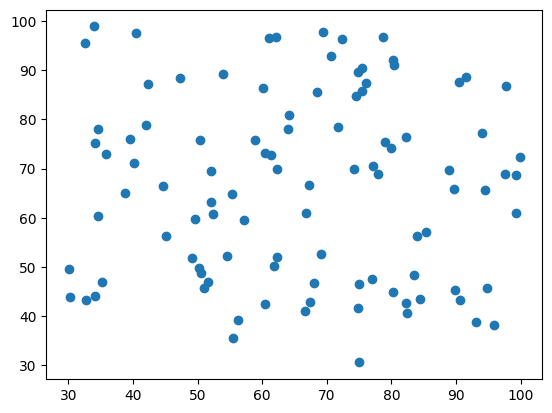

In [10]:
db = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw4/exams.csv', header=None).to_numpy()
data, labels = db[:,:-1], db[:,-1]

plt.scatter(data[:, 0], data[:, 1])
plt.show()

We are going to divide the data into 2 clusters. <br/>
Define Kmeans object and fit the data.

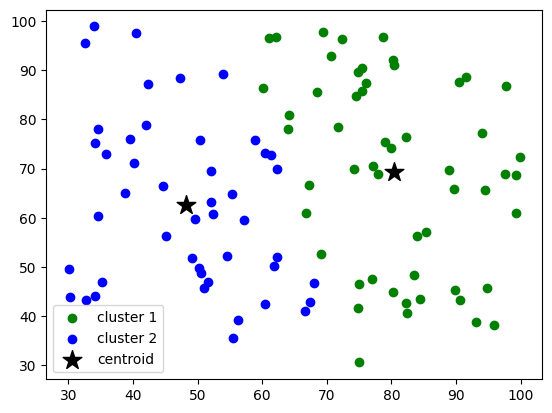

In [11]:
clust = Kmeans(n_clusters=2)
clust.fit(data)

# This code plots the clustered data with centroids
labels = clust.labels
centroids = clust.centroids

c0 = data[labels == 0]
c1 = data[labels == 1]

plt.scatter(c0[:,0], c0[:,1], c='green', label='cluster 1')
plt.scatter(c1[:,0], c1[:,1], c='blue', label='cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='black', label='centroid')
plt.legend()

plt.show()

Use the Elbow Method to choose another number of centroids between 1-10. <br/>
<font color='red'>as we can see in the graph the optimal number of clusters in my opinion is 6 , because thats where the sum of squared distances is realtively very low and going for higher number of clusters than that wont greatly reduce the sum of squared difference much , and thus we can save the computational complexity by only doing 6 clusters </font>

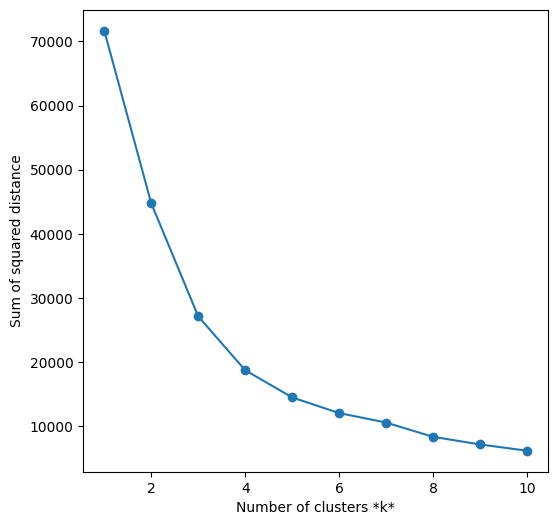

In [12]:
sse = []
list_k = list(range(1, 11))

for k in list_k:
  kmeans = Kmeans(n_clusters=k)
  kmeans.fit(data)
  error_of_current_clustering=kmeans.error
  sse.append(error_of_current_clustering)

'''Plot sse against k'''
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()

Apply clustering with the selected k

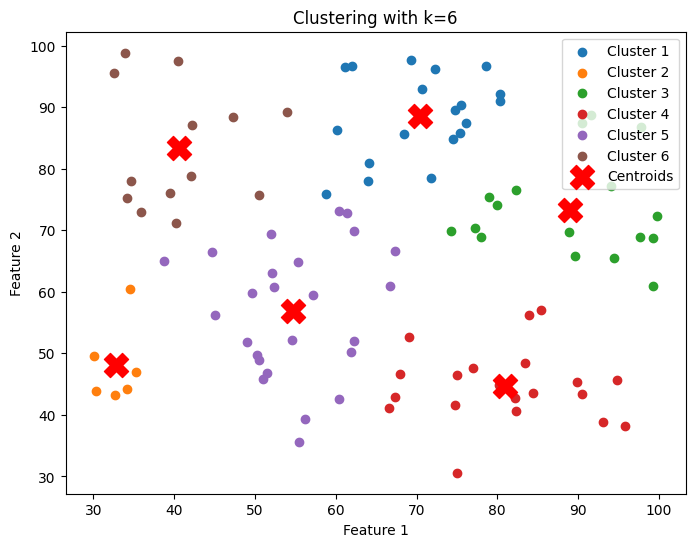

In [13]:
# Implement here
optimal_k = 6

# Apply clustering with the selected k
kmeans = Kmeans(n_clusters=optimal_k)
kmeans.fit(data)

# Get the cluster labels
labels = kmeans.predict(data)

# Plot the clustered data
plt.figure(figsize=(8, 6))
for i in range(optimal_k):
    plt.scatter(data[labels == i, 0], data[labels == i, 1], label=f'Cluster {i+1}')
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(f'Clustering with k={optimal_k}')
plt.legend()
plt.show()

Now, you will compress some image using k-means. <br/>
Here, you are given image from size 400x600x3. The last parameter is the number of channels. 3 channels means that the image is colored (unlike 1 in, which is grayscale). <br/>
Our goal is to reduce the number of colors to 20 and represent (compress) the photo using those 20 colors only. <br/>

Motivation: the original image requires 400x600x3x8 bits, while the new image will require only 400x600x5 + 20x24 bits, almost 5 times smaller!<br/>
To really do this, we will take the image and treat every pixel as a data point, where each data point is in 3d space (r,g,b). Then, we cluster into 20 centroids, and we assign each pixel to a centroid. This will allow us to represent the image using only 20 colors.


In [14]:
#@title helper function

import urllib.request

def read_image(url):
    req = urllib.request.urlopen(url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    return cv2.imdecode(arr, -1)

Complete the missing code

In [15]:
from sklearn.cluster import KMeans
import cv2

img = read_image('https://sharon.srworkspace.com/ml/datasets/hw4/image.jpg')
img_size = img.shape

# Reshape it to be 2-dimension
X = img.reshape(img_size[0] * img_size[1], img_size[2])		# Turn hxwx3 into (h*w)x3

# Run the Kmeans algorithm
km = KMeans(n_clusters=20)
km.fit(X)

'''
The km has the following properties:
(*) km.labels_ is an array size (pixels, 20), will give each pixel its class from 20 classes (values are between 0-19)
(*) km.cluster_centers_ is an array size 20x3, where the ith row represents the color value for the ith label.
	For example, cluster_centers_[0] = [r,g,b], the first center.
'''

# Use the centroids to compress the image
img_compressed = km.cluster_centers_[km.labels_]# Use cluster_centers_ and labels_
img_compressed = np.clip(img_compressed.astype('uint8'), 0, 255)

# Reshape X_recovered to have the same dimension as the original image 128 * 128 * 3'''
img_compressed = img_compressed.reshape(img_size[0], img_size[1], img_size[2])

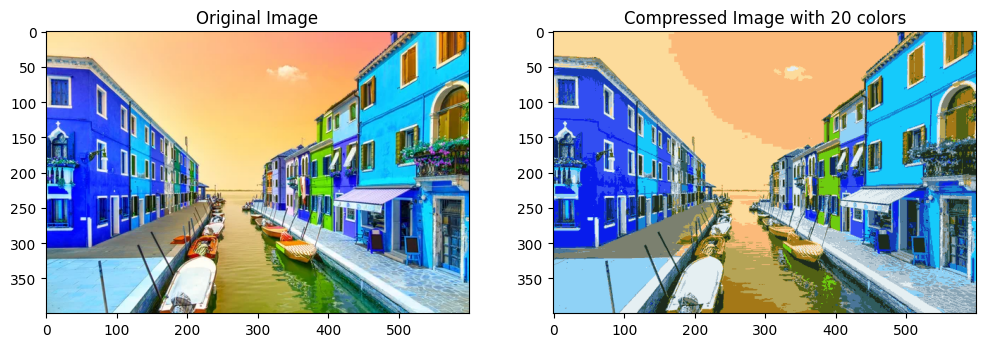

In [16]:

# Plot the original and the compressed image next to each other'''
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(img_compressed)
plt.title(f'Compressed Image with {km.n_clusters} colors')

plt.show()

## load smiling dataset

In the third question, we will deal with the Smiling-face dataset, which determines if a person is smiling or not. You will try several models and hope to get good results<br/>
Your task is: run the following section and make sure your understand what's going on.

Go to your <a href="https://www.kaggle.com/">Kaggle</a> account and under the settings, generate new API token. <br/>
This will give you the json file, which you will upload here.

In [17]:
# The script expects you to upload JSON file to it!

! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download chazzer/smiling-or-not-face-data
! unzip -q smiling-or-not-face-data.zip -d data

Saving kaggle.json to kaggle.json
ref                                                        title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datazng/shopping-mall-customer-data-segmentation-analysis  Shopping Mall Customer Data Segmentation Analysis    6MB  2024-08-04 20:36:31           1090         32  0.88235295       
myrios/cost-of-living-index-by-country-by-number-2024      Cost of Living Index by Country                      3KB  2024-07-19 06:25:42           1959         22  1.0              
waqi786/cats-dataset                                       🐾 Cats Dataset                                       6KB  2024-07-31 06:12:49           2014         43  1.0              
abhayayare/employee-data-simulation-it-industry         

import libraries

In [18]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

process the images

In [19]:
def proccess_data(folder):
	image_arrays = []
	for filename in os.listdir(folder):
		file_path = os.path.join(folder, filename)
		image = cv2.imread(file_path)
		gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		image_arrays.append(gray_image)
	return np.array(image_arrays)

smile = proccess_data('./data/smile')
non_smile = proccess_data('./data/non_smile')

dataset = np.vstack((smile,non_smile))
dataset = dataset / 255

labels = [0] * len(smile) + [1] * len(non_smile)
labels = np.array(labels)

display smiling and non-smiling image.

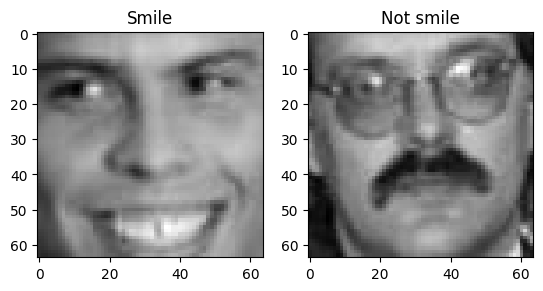

In [20]:
plt.subplot(121)
plt.title("Smile")
plt.imshow(smile[0], cmap='gray')

plt.subplot(122)
plt.title("Not smile")
plt.imshow(non_smile[0], cmap='gray')

plt.show()

print the smiling and non-smiling data + the united dataset along with labels.

In [21]:
print(f'smile array size is (images, height, width)={smile.shape}')
print(f'non smile array size is (images, height, width)={non_smile.shape}')
print()
print(f'dataset array size is {dataset.shape}')
print(f'labels array size is {labels.shape}')

smile array size is (images, height, width)=(600, 64, 64)
non smile array size is (images, height, width)=(603, 64, 64)

dataset array size is (1203, 64, 64)
labels array size is (1203,)


Prepear train and test datasets, print their structure. Since you have to deal with 1d features, we flatten the squared image

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size = 0.2, stratify=labels, random_state=42)

print(f'train size is {x_train.shape} and labels size is {y_train.shape}')
print(f'test size is {x_test.shape} and labels size is {y_test.shape}')
print()

x_train_flatten = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test_flatten = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

print(f'flattened train size is {x_train_flatten.shape} ')
print(f'flattened test size is {x_test_flatten.shape}')

train size is (962, 64, 64) and labels size is (962,)
test size is (241, 64, 64) and labels size is (241,)

flattened train size is (962, 4096) 
flattened test size is (241, 4096)


## Question 3 - PCA, LDA

You will try to classify the smiling faces dataset using feature reduction and KNN (since there are 4096 features!). Than you will compare it to LDA

import libraries

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

Implement PCA to reduce the dimension of the images from 4096=64x64 to 81=9x9. For time effciency, DONT use any loops here.

Hint: Implement inverse_transform to recover the original vector from the compressed one. <br/>
Hint: When dealing with symmetric matrix, you can call eigh instead of eig function of numpy, its much faster.

In [24]:

def PCA_train(data, k):
    # Mean center the data
    mu = np.mean(data, axis=0)
    data_centered = data - mu

    # Compute the covariance matrix instead of scatter matrix because it gives normalization (we said to normalize the vectors in the tutorial)
    covariance_matrix = np.cov(data_centered, rowvar=False)

    # Compute eigenvalues and eigenvectors using eigh (for symmetric matrices)
    eigvals, eigvecs = np.linalg.eigh(covariance_matrix)

    # Sort the eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigvals)[::-1]
    sorted_eigvals = eigvals[sorted_indices]
    sorted_eigvecs = eigvecs[:, sorted_indices]

    # Select the top k eigenvectors
    E = sorted_eigvecs[:, :k]

    # Print the shape of the eigenvector matrix E
    print(f"Shape of E: {E.shape}")
    # Print the shape of the centered data
    print(f"Shape of data_centered: {data_centered.shape}")

    # Transform the data to k dimensions , Zcentered * E  - (962,4096) * (4096,81) = (962,81)
    data_reduced = np.dot(data_centered, E)

    # Print the shape of the reduced data
    print(f"Shape of data_reduced: {data_reduced.shape}")

    return data_reduced, mu, E,sorted_eigvals

def PCA_test(test, mu, E):
    # Mean center the test data
    test_centered = test - mu

    # Transform the test data to the k-dimensional space
    test_reduced = np.dot(test_centered, E)

    return test_reduced

def recover_PCA(data_reduced, mu, E):
    # Recover the original data from the reduced dimensions
    data_recovered = np.dot(data_reduced, E.T) + mu
    return data_recovered


Apply the PCA. <br/>
Make sure you fit the PCA model only to the training set (but apply it to both training and test sets). <br/>

In [25]:
# Number of components to keep
k = 81

# Fit PCA to the training data
x_train_new, mu, eig,sorted_eigvals = PCA_train(x_train_flatten, k)

# Apply the PCA transformation to the test data
x_test_new = PCA_test(x_test_flatten, mu, eig)


Shape of E: (4096, 81)
Shape of data_centered: (962, 4096)
Shape of data_reduced: (962, 81)


Pick another random image and show the result of applying PCA to it, and then try to recover the whole size again.

Shape of x_train_new: (962, 81)
Shape of x_test_new: (241, 81)


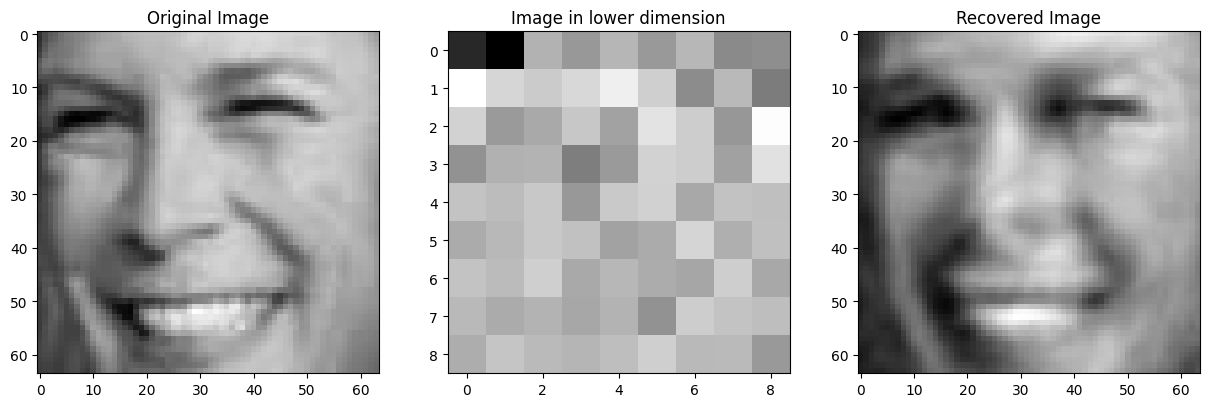

In [26]:

# Verify the shapes
print(f"Shape of x_train_new: {x_train_new.shape}")
print(f"Shape of x_test_new: {x_test_new.shape}")

# Pick a random image from the training dataset
random_idx = np.random.randint(0, x_train_flatten.shape[0])
original_image = x_train_flatten[random_idx]

# Apply the PCA transformation to this random image
random_image_reduced = PCA_test(np.array([original_image]), mu, eig)

# Recover the image back to its original size
recovered_image = recover_PCA(random_image_reduced, mu, eig).reshape(64, 64)

# Plot the original, reduced, and recovered images
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(131)
plt.title("Original Image")
plt.imshow(original_image.reshape(64, 64), cmap='gray')

# Image in lower dimension (flattened for visualization)
plt.subplot(132)
plt.title("Image in lower dimension")
plt.imshow(random_image_reduced.reshape(9, 9), cmap='gray')

# Recovered Image
plt.subplot(133)
plt.title("Recovered Image")
plt.imshow(recovered_image, cmap='gray')

plt.show()

Before training the model, use EIG_CDF, that given eigenvalues, draws a CDF of them like here:<br/><br/>

![Picture1.jpg](https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcS3mOZk1x4X3ap9nuMnst5W5pMgOXF8r3Tmx1QcFX9mba_lleuB)

As seen in the tutorials, we use them to see how much "energy" we preserve from the data. Use this to choose optimal dimension to reduce into, such the preserves 95% of the energy.

Shape of E: (4096, 81)
Shape of data_centered: (962, 4096)
Shape of data_reduced: (962, 81)
Shape of eigenvalues: (4096,)


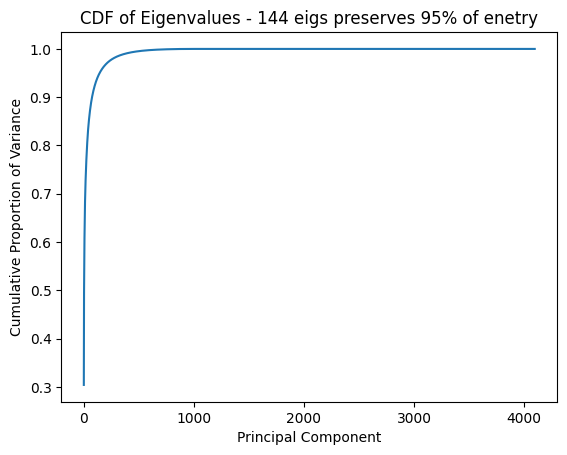

In [27]:
def EIG_CDF(eig_list):
	sorted_eigenvalues = np.sort(eig_list)[::-1]

	eigenvalues_cumsum = np.cumsum(sorted_eigenvalues)

	eigenvalues_cumsum_normalized = eigenvalues_cumsum / eigenvalues_cumsum[-1]
	# Determine the number of components that preserve at least 95% of the variance
	threshold = 0.95
	amount = np.argmax(eigenvalues_cumsum_normalized >= threshold)

	plt.plot(np.arange(1, len(sorted_eigenvalues)+1), eigenvalues_cumsum_normalized)
	plt.xlabel('Principal Component')
	plt.ylabel('Cumulative Proportion of Variance')
	plt.title(f'CDF of Eigenvalues - {amount} eigs preserves 95% of enetry')
	plt.show()



x_train_new, mu, eig, sorted_eigvals = PCA_train(x_train_flatten, k)

# Call EIG_CDF to determine the number of components that preserve 95% variance
print(f"Shape of eigenvalues: {sorted_eigvals.shape}")  # Should be (4096,)
EIG_CDF(sorted_eigvals)

For the same image as before, show the result of applying PCA to it and recovering.<br/>
Is the result better? What is different from 81 dimensions? <br/>
<font color='red'>The difference lies in the amount of preserved information we got from the images , as we can see when we used 144 ( 12 * 12 ) we got an accuracy of over 95% in terms of keeping the variance compared to that when we did only 81 dimensions we got about 75-85% and we can clearly see the difference since now the reconstructed image resembles the original better.</font>

Shape of E: (4096, 144)
Shape of data_centered: (962, 4096)
Shape of data_reduced: (962, 144)


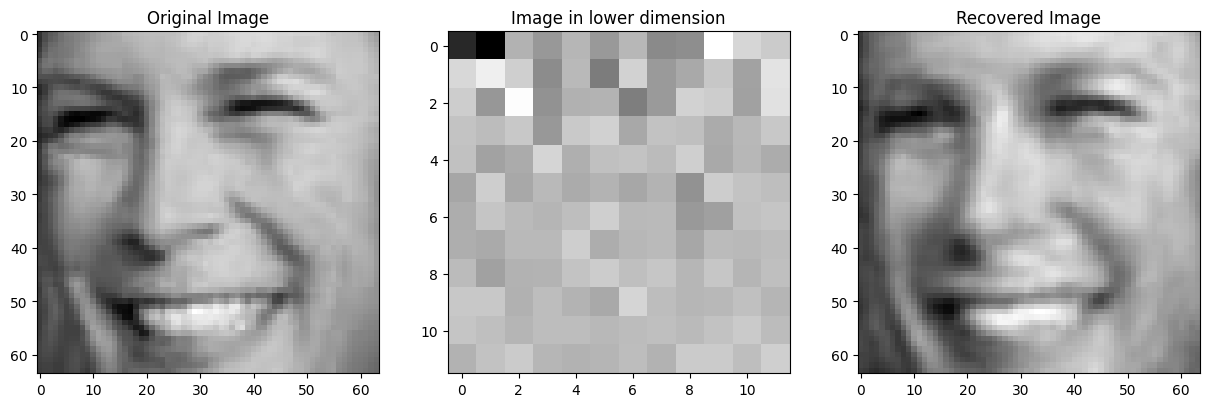

In [28]:

k_comparison = 144


# Fit PCA to the training data
x_train_new, mu, eig,sorted_eigvals = PCA_train(x_train_flatten, k_comparison)

# Apply the PCA transformation to the test data
x_test_new = PCA_test(x_test_flatten, mu, eig)

# Apply the PCA transformation to this random image
random_image_reduced = PCA_test(np.array([original_image]), mu, eig)

# Recover the image back to its original size
recovered_image = recover_PCA(random_image_reduced, mu, eig).reshape(64, 64)

# Plot the original, reduced, and recovered images
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(131)
plt.title("Original Image")
plt.imshow(original_image.reshape(64, 64), cmap='gray')

# Image in lower dimension (flattened for visualization)
plt.subplot(132)
plt.title("Image in lower dimension")
plt.imshow(random_image_reduced.reshape(12, 12), cmap='gray')

# Recovered Image
plt.subplot(133)
plt.title("Recovered Image")
plt.imshow(recovered_image, cmap='gray')

plt.show()

Now, you are ready to train the model. Use KNN, tune the best k using cross_val_score (with sklearn)

Shape of E: (4096, 81)
Shape of data_centered: (962, 4096)
Shape of data_reduced: (962, 81)
k=1, avg accuracy=0.7110589378238343
k=2, avg accuracy=0.739119170984456
k=3, avg accuracy=0.7474579015544041
k=4, avg accuracy=0.776581390328152
k=5, avg accuracy=0.7474740932642486
k=6, avg accuracy=0.7599309153713298
k=7, avg accuracy=0.755769645941278
k=8, avg accuracy=0.7744710708117444
k=9, avg accuracy=0.7578259930915372
k=10, avg accuracy=0.7713676597582038
k=11, avg accuracy=0.7578421848013817
k=12, avg accuracy=0.7807426597582038
k=13, avg accuracy=0.7786701208981002
k=14, avg accuracy=0.7869926597582038
k=15, avg accuracy=0.7745034542314334
k=16, avg accuracy=0.7839108376511227
k=17, avg accuracy=0.7786647236614853
k=18, avg accuracy=0.7776122625215889
k=19, avg accuracy=0.7786377374784111
k=20, avg accuracy=0.7817951208981001


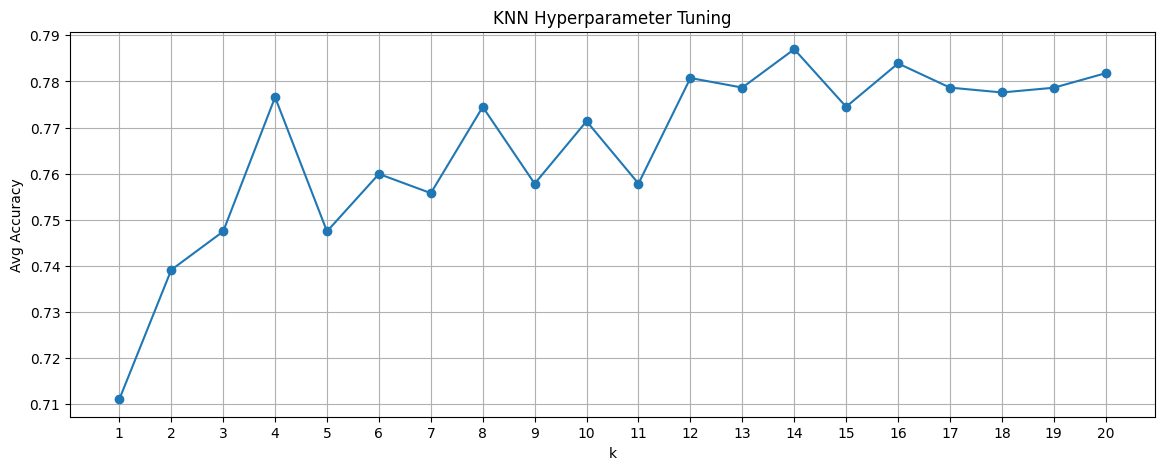

In [29]:
# Implement here

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# Number of components to keep for PCA
k_pca = 81

# Fit PCA to the training data
x_train_new, mu, eig, sorted_eigvals = PCA_train(x_train_flatten, k_pca)

# Apply PCA transformation to the test data
x_test_new = PCA_test(x_test_flatten, mu, eig)

# Range of k values to test for KNN
ks = list(range(1, 21))

# List to store average accuracy for each k
accs = []

# Perform cross-validation to find the best k
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train_new, y_train, cv=5)  # 5-fold cross-validation
    avg_score = scores.mean()
    accs.append(avg_score)
    print(f"k={k}, avg accuracy={avg_score}")

# Plot the average accuracy vs. k values
plt.figure(figsize=(14, 5))
plt.plot(ks, accs, marker='o')
plt.xlabel('k')
plt.xticks(ks)
plt.ylabel('Avg Accuracy')
plt.title('KNN Hyperparameter Tuning')
plt.grid(True)
plt.show()


Print the accuracy of your model on the test set.

In [30]:
from sklearn.metrics import accuracy_score

# Select the best k based on the highest average accuracy
best_k = ks[np.argmax(accs)]
print(f'Best k found: {best_k}')

# Train the KNN model using the best k on the entire training set
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(x_train_new, y_train)

# Transform the test data using the PCA components from training
x_test_transformed = PCA_test(x_test_flatten, mu, eig)

# Predict the labels for the test set
y_pred = knn_best.predict(x_test_transformed)

# Calculate the accuracy on the test set
acc = accuracy_score(y_test, y_pred)
print(f'acc on test is {acc}')

Best k found: 14
acc on test is 0.7800829875518672


Answer the following sum-up questions: <br/>
- What pre-proccessing actions were done on the data?
- Should we apply Standard Scaler? Why?
- Suggest one idea for improvement (rather than LDA)

<font color='red'>Question 1 )  Flattening: The original images (64x64) were flattened into 1D vectors of length 4096 for processing.
Mean Centering: The mean of each feature (pixel) was calculated and subtracted from the dataset to center the data around zero. This is essential for PCA.
PCA Transformation: Principal Component Analysis (PCA) was applied to reduce the dimensionality of the data from 4096 to 81 dimensions. This involved calculating the covariance matrix, computing the eigenvalues and eigenvectors, and projecting the data onto the top 81 principal components.
Question 2 ) Applying a standard scaler is a good idea because PCA is variance sensitive , since PCA identifies the directions (principal components) where the variance in the data is maximal. If the features are not scaled, features with larger ranges can dominate the PCA process, leading to misleading principal components.Also by applying standard scaler we get consistent contribution to different features meaning that Standard Scaler ensures that each feature contributes equally to the PCA transformation, making the analysis more balanced and accurate. Question 3 ) there are multiple ideas for improvement such as Ensemble methods like Bagging (Bootstrap Aggregating) and Boosting that can significantly improve model performance by combining the predictions of multiple models to reduce overfitting and improve generalization.  </font>


For the second part, we will use LDA on the data <b>before</b> PCA. <br/>
Use the model of LinearDiscriminantAnalysis from Sklearn, train the data and print the accuracy test using KNN. <br/>
Use the best k you found earlier.

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

# Number of components to keep for LDA (should be less than or equal to the number of classes - 1)
num_classes = len(np.unique(y_train))
num_lda_components = min(num_classes - 1, x_train_flatten.shape[1])

# Apply LDA on the training data
lda = LinearDiscriminantAnalysis(n_components=num_lda_components)
x_train_lda = lda.fit_transform(x_train_flatten, y_train)

# Transform the test data using the LDA model
x_test_lda = lda.transform(x_test_flatten)

# Train the KNN model using the transformed data and the best k found earlier
best_k = 14
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x_train_lda, y_train)

# Predict on the test set
y_test_pred = knn.predict(x_test_lda)

# Calculate the accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy on test set using LDA and KNN with k={best_k}: {test_accuracy}')






# using the data after PCA and using the same k
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

# Number of components to keep for PCA
k = 81

# Fit PCA to the training data
x_train_pca, mu, eig, sorted_eig = PCA_train(x_train_flatten, k)

# Apply the PCA transformation to the test data
x_test_pca = PCA_test(x_test_flatten, mu, eig)

# Number of components to keep for LDA (should be less than or equal to the number of classes - 1)
num_classes = len(np.unique(y_train))
num_lda_components = min(num_classes - 1, x_train_pca.shape[1])

# Apply LDA on the PCA-transformed training data
lda = LinearDiscriminantAnalysis(n_components=num_lda_components)
x_train_pca_lda = lda.fit_transform(x_train_pca, y_train)

# Transform the PCA-transformed test data using the LDA model
x_test_pca_lda = lda.transform(x_test_pca)

# Train the KNN model using the PCA + LDA transformed data and the best k found earlier
best_k = 14
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x_train_pca_lda, y_train)

# Predict on the test set
y_test_pred_pca_lda = knn.predict(x_test_pca_lda)

# Calculate the accuracy on the test set
test_accuracy_pca_lda = accuracy_score(y_test, y_test_pred_pca_lda)
print(f'Accuracy on test set using PCA + LDA and KNN with k={best_k}: {test_accuracy_pca_lda}')



Accuracy on test set using LDA and KNN with k=14: 0.7261410788381742
Shape of E: (4096, 81)
Shape of data_centered: (962, 4096)
Shape of data_reduced: (962, 81)
Accuracy on test set using PCA + LDA and KNN with k=14: 0.8796680497925311


Now, repeat the same as above, but using the data <b>after</b> PCA and using the same k.
- Was the combination of PCA and LDA helpful more than LDA alone?
- Comparing LDA alone vs PCA alone (as dimensionality reduction), which one was better to this problem? Justify.

<font color='red'> (1) The combination of PCA and LDA was indeed more helpful than LDA alone since it gave accuracy of 0.89 compared to 0.82. This approach leveraged the strengths of both techniques: PCA's noise reduction and variance preservation, followed by LDA's class separability focus which made it deliver the best results.

(2) In comparison between LDA alone and PCA alone as dimensionality reductions the better option was LDA alone that gave 0.82 compared to 0.8. and this stems from the fact that LDA is specifically designed for maximizing class separability. It uses label information to find the projection that best separates the different classes.
PCA does not consider class labels and focuses solely on maximizing variance. While this can be useful for capturing the most significant features, it might not always align with the goal of maximizing class separability for classification tasks.
In this case, the LDA's ability to use class labels for its projections provided a more suitable feature space for the KNN classifier, resulting in higher accuracy.
</font>

## Question 4 - Adaboost
See attached pdf in moodle assignment!



## Question 5 - Kernel PCA - 10 pts bonus
See attached pdf in moodle assignment! <br/>
Here you will implement the parts that are relevant for that question

In [33]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [34]:
def proccess_data(folder):
	image_arrays = []
	for filename in os.listdir(folder):
		file_path = os.path.join(folder, filename)
		image = cv2.imread(file_path)
		gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		image_arrays.append(gray_image)
	return np.array(image_arrays)

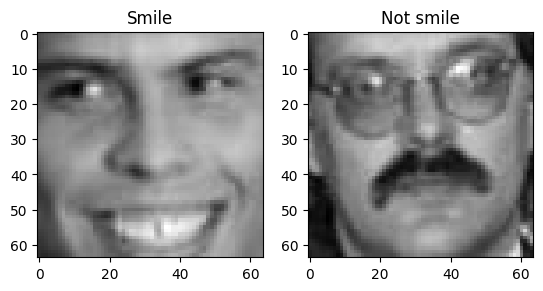

In [35]:
smile = proccess_data('./data/smile')
non_smile = proccess_data('./data/non_smile')

dataset = np.vstack((smile,non_smile))
dataset = dataset / 255

labels = [0] * len(smile) + [1] * len(non_smile)
labels = np.array(labels)

plt.subplot(121)
plt.title("Smile")
plt.imshow(smile[0], cmap='gray')

plt.subplot(122)
plt.title("Not smile")
plt.imshow(non_smile[0], cmap='gray')

plt.show()

In [40]:
print(f'smile array size is (images, height, width)={smile.shape}')
print(f'non smile array size is (images, height, width)={non_smile.shape}')
print()
print(f'dataset array size is {dataset.shape}')
print(f'labels array size is {labels.shape}')

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size = 0.2, stratify=labels, random_state=42)

print(f'train size is {x_train.shape} and labels size is {y_train.shape}')
print(f'test size is {x_test.shape} and labels size is {y_test.shape}')
print()

x_train_flatten = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test_flatten = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

print(f'flattened train size is {x_train_flatten.shape} ')
print(f'flattened test size is {x_test_flatten.shape}')

smile array size is (images, height, width)=(600, 64, 64)
non smile array size is (images, height, width)=(603, 64, 64)

dataset array size is (1203, 64, 64)
labels array size is (1203,)
train size is (962, 64, 64) and labels size is (962,)
test size is (241, 64, 64) and labels size is (241,)

flattened train size is (962, 4096) 
flattened test size is (241, 4096)


In [44]:
# Apply Kernel PCA with 'cosine' kernel
kpca = KernelPCA(kernel='cosine', n_components=2)
X_train_kpca = kpca.fit_transform(x_train_flatten)
X_test_kpca = kpca.transform(x_test_flatten)

# Apply regular PCA with the same number of components as Kernel PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(x_train_flatten)
X_test_pca = pca.transform(x_test_flatten)

# Determine an appropriate number of neighbors (125 in this case)
n_neighbors = 125

# Train KNN classifier with the determined number of neighbors on Kernel PCA transformed data
knn_kpca = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_kpca.fit(X_train_kpca, y_train)
y_pred_kpca = knn_kpca.predict(X_test_kpca)
accuracy_kpca = accuracy_score(y_test, y_pred_kpca)
print(f"Kernel PCA + KNN Accuracy: {accuracy_kpca}")

# Train KNN classifier with the determined number of neighbors on regular PCA transformed data
knn_pca = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_pca.fit(X_train_pca, y_train)
y_pred_pca = knn_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"Regular PCA + KNN Accuracy: {accuracy_pca}")

# Compare the performance
if accuracy_kpca > accuracy_pca:
    print("Kernel PCA performed better than regular PCA.")
elif accuracy_kpca < accuracy_pca:
    print("Regular PCA performed worse than Kernel PCA.")
else:
    print("Both approaches performed equally")

Kernel PCA + KNN Accuracy: 0.5892116182572614
Regular PCA + KNN Accuracy: 0.5892116182572614
Both approaches performed equally
